In [40]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import time

In [41]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [42]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [43]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

startTime = time.time()
history = model.fit(train_images, train_labels, epochs=50, 
                    validation_data=(test_images, test_labels))

finishTime = time.time()

Epoch 1/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.7454 - accuracy: 0.3579 - val_loss: 1.3377 - val_accuracy: 0.5203
Epoch 2/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2222 - accuracy: 0.5673 - val_loss: 1.0815 - val_accuracy: 0.6214
Epoch 3/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0418 - accuracy: 0.6334 - val_loss: 1.0182 - val_accuracy: 0.6502
Epoch 4/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.9231 - accuracy: 0.6757 - val_loss: 0.9336 - val_accuracy: 0.6759
Epoch 5/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.8597 - accuracy: 0.6971 - val_loss: 0.9184 - val_accuracy: 0.6808
Epoch 6/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.7849 - accuracy: 0.7266 - val_loss: 0.9280 - val_accuracy: 0.6823
Epoch 7/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.7392 - accuracy: 0.7402 - val_loss: 0.9369 - val_accuracy:

In [45]:
timeTaken = finishTime - startTime
minutes = timeTaken // 60
seconds = round((timeTaken % 60), 1)
print(f"Time taken: {minutes}m, {seconds}s" )

Time taken: 6.0m, 24.6s


313/313 - 1s - loss: 2.5198 - accuracy: 0.6774


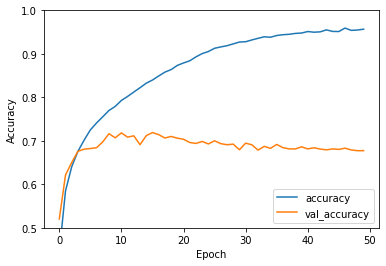

In [46]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [47]:
print(test_acc)

0.6773999929428101
